In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io
from collections import Counter
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
"""
X and Y Components of Training and Testing Data
"""
train_32x32 = '../dataset/SVHN/train_32x32.mat'
test_32x32 = '../dataset/SVHN/test_32x32.mat'
train_dataset = scipy.io.loadmat(train_32x32)['X']
train_labels = scipy.io.loadmat(train_32x32)['y']
test_dataset = scipy.io.loadmat(test_32x32)['X']
test_labels = scipy.io.loadmat(test_32x32)['y']
print('Training set', train_dataset.shape, train_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (32, 32, 3, 73257) (73257, 1)
Test set (32, 32, 3, 26032) (26032, 1)


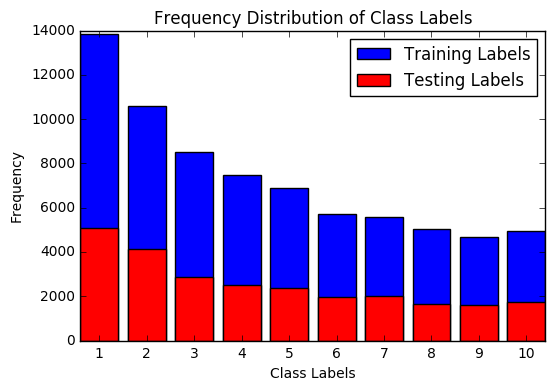

73257 Images with 32 x 32 RGB grid


In [3]:
shape_train = train_dataset.shape
shape_test = test_dataset.shape
"""
Plotting Class Labels against their respective frequencies in a Bar Graph
"""
temp_labels = train_labels.reshape(73257).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', label='Training Labels')
plt.xticks(range(len(temp_labels)), temp_labels.keys())
temp_labels = test_labels.reshape(26032).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='red', label='Testing Labels')
plt.legend()
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')
plt.show()

print(shape_train[3], "Images with", shape_train[0], "x", shape_train[0], "RGB grid")

In [4]:
#==================NORMALISATION AND PREPROCESSING=============================================

train_dataset = train_dataset.astype('float32') / 128.0 - 1
test_dataset = test_dataset.astype('float32') / 128.0 - 1


"""
Converting Labels to One Hot Encoding and Image Matrix to favourable dimensions
"""
def reformat(data, Y):
    xtrain = []
    trainLen = data.shape[3]
    for x in xrange(trainLen):
        xtrain.append(data[:,:,:,x])
    xtrain = np.asarray(xtrain)
    Ytr=[]
    for el in Y:
        temp=np.zeros(10)
        if el==10:
            temp[0]=1
        elif el==1:
            temp[1]=1
        elif el==2:
            temp[2]=1
        elif el==3:
            temp[3]=1
        elif el==4:
            temp[4]=1
        elif el==5:
            temp[5]=1
        elif el==6:
            temp[6]=1
        elif el==7:
            temp[7]=1
        elif el==8:
            temp[8]=1
        elif el==9:
            temp[9]=1
        Ytr.append(temp)
    return xtrain, np.asarray(Ytr)

train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (73257, 32, 32, 3) (73257, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
"""
Hyperparameters 
"""
image_size = 32
num_labels = 10
num_channels = 3

batch_size = 128
patch_size =5
depth = 16
num_hidden = 256


## With L2 Regularization

In [7]:
graph = tf.Graph()

with graph.as_default():
    # input data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)
    
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    # layer 1
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # layer 2
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # layer 3
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal(
            [size3 * size3 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Layer 4
    layer4_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    dropout = tf.placeholder(tf.float32)
    
    # Model
    def model(data):
        # C1 input 28 x 28
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        # S2 input 24 x 24
        pool2 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        # C3 input 12 x 12
        conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
        bias3 = tf.nn.relu(conv3 + layer2_biases)
        # S4 input 8 x 8
        pool4 = tf.nn.max_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        # F6 input 4 x 4
        shape = pool4.get_shape().as_list()
        reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        #   Dropout
        dropout_layer = tf.nn.dropout(hidden, 0.9)
        
        return tf.matmul(dropout_layer, layer4_weights) + layer4_biases
    
    # Training computation
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights))
    
    # Optimizer
    global_step = tf.Variable(0)
    #learning rate with exponential decay.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95) 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    # Saver
    #saver = tf.train.Saver()

In [8]:
num_steps = 30001
train_performance = []
test_performance = []
human_accu = 0
x_train = []
x_test = []

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    print('Initialized')
    average = 0
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accu = accuracy(predictions, batch_labels)
        
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accu)
            train_performance.append(accu)
            x_train.append(step/100)
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        average += accu
    print('Average Accuracy :', average/num_steps)
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
    print("END OF TRAINING")
    average = 0
    for step in range(num_steps):
        #   Constucting the batch from the data set
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #   Dictionary to be fed to TensorFlow Session
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        #   Calculating the Accuracy of the predictions
        accu = accuracy(predictions, batch_labels)
        
        # Finding if accuracy is greater than 98%
        if(accu >= 96.0):
            human_accu +=1
        
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accu)
            test_performance.append(accu)
            x_test.append(step/100)
        average += accu
    print("Average Accuracy : ", average / num_steps)
    print("END OF TESTING")
    
    print("Performane above 96%:", 100*human_accu/num_steps )
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.748292
Minibatch accuracy: 7.0%
Minibatch loss at step 1000: 1.239450
Minibatch accuracy: 78.9%
Minibatch loss at step 2000: 1.091912
Minibatch accuracy: 77.3%
Minibatch loss at step 3000: 0.785300
Minibatch accuracy: 84.4%
Minibatch loss at step 4000: 0.687052
Minibatch accuracy: 89.1%
Minibatch loss at step 5000: 0.950445
Minibatch accuracy: 89.1%
Minibatch loss at step 6000: 0.499883
Minibatch accuracy: 93.0%
Minibatch loss at step 7000: 0.534618
Minibatch accuracy: 91.4%
Minibatch loss at step 8000: 0.605112
Minibatch accuracy: 88.3%
Minibatch loss at step 9000: 0.563186
Minibatch accuracy: 87.5%
Minibatch loss at step 10000: 0.355411
Minibatch accuracy: 95.3%
Minibatch loss at step 11000: 0.416531
Minibatch accuracy: 92.2%
Minibatch loss at step 12000: 0.467504
Minibatch accuracy: 90.6%
Minibatch loss at step 13000: 0.388765
Minibatch accuracy: 93.8%
Minibatch loss at step 14000: 0.472448
Minibatch accuracy: 93.8%
Minibatch loss at step 1500